# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Project Overview

<b>For my capstone project, I have two primary business inquiries to address. </b>
 - Firstly, I will investigate the main factors that contribute to the success of an offer on the Starbucks app. 
 - Secondly, I will examine whether it is possible to predict whether a user would take up an offer using the data available, including user demographics and offer characteristics. <hr>
This project is based on Udacity's Data Scientist Nanodegree course, using synthetic data that mimics the behavior of customers on the Starbucks rewards mobile app. According to the provided background information, Starbucks sends out offers to mobile app users every few days, but not all users receive the same offer, and some users may not receive an offer in certain weeks.

## Objective

To address the problem statement outlined earlier, I plan to investigate (1) the primary factors that contribute to offer effectiveness and (2) whether it is possible to predict if a user will accept an offer. The provided data includes three datasets: 
 - Offer portfolio containing offer attributes, demographic data for each customer, and transactional records of app events.
 - I will use three supervised machine learning models for classification, applying them to data from three distinct offer types. 
 - I will analyze feature importances to identify the main drivers of offer effectiveness and explore whether the model can predict user behavior. 
 <br>Additionally, I will investigate the characteristics of users who accept or reject an offer. Furthermore, I conducted two additional models to assess the use of an all-in-one model and build a regression model to predict the amount a user will spend when influenced by an offer.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio data
The schema is as follows, per the information provided by Udacity:

<b>portfolio.json</b>


the offer's id (string). offer_type (string) identifier - the type of offer, such as a BOGO, discount, or informational challenge (int) reward given for completing an offer length (int) - minimum spend necessary to finish an offer reward (int) - channels (string list)
There are also three other offer kinds listed in the additional information provided about the offers:

Buy one, get one free, or receive a discount when you make a purchase.
Informational - offers details on products
As a result, the schema is rather simple since it provides the characteristics of three separate offer kinds. Although the period was not specified, I inferred from the context that it was expressed in terms of days.

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


<b>Lists that are nested are found in the channels column. I therefore notice that in order for the column to become categorical variables in my dataset, I will need to expand it later on during preprocessing. I also observe that each scale is different; for instance, the difficulty is measured in dollars, whereas the time is measured in days. Therefore, some feature scaling will be required.</b>

In [3]:
#checking forthe null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

<b>The good news is that this dataset has no missing values, so we won't need to impute any values or decide how to get rid of them during preprocessing.

In [4]:
#checking number of unique offers
portfolio.id.nunique()

10

In [5]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

<b>There are 10 different offer ids that we need to remember, including 2 informative types and 4 bogo and discount types apiece.

## 2. Demographic data

The profile dataset includes customer demographic information. The variables and schema are as follows:

<b>profile.json</b>

age (int) - the customer's age when they become members (int) - the day the customer made their app account. female (str) - The customer's gender (notice that some entries use 'O' for other rather than M or F). id (str) - Revenue from client IDs (float) - The client's income Given that it includes the customer's demographic profile, it is also rather simple.

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


<b>The gender and income columns in the first five lines already include some null values, while the age column has some values that don't make sense (such as 118).

In [7]:
#checking for the null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

<b>The gender and income both exhibit zero values, as was expected. The good news is that income values that are 0 for gender 0 for income.

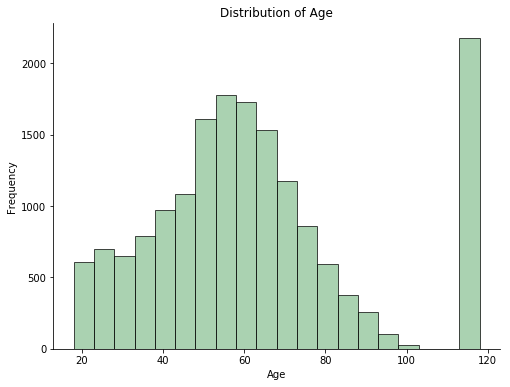

In [8]:
#checking the  distribution of age column
import matplotlib.pyplot as plt
# Set the figure size
plt.figure(figsize=(8,6))
# Plot the histogram
plt.hist(profile.age, bins=20, color='#86bf91', edgecolor='black', alpha=0.7)
# Add labels and title
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Show the plot
plt.show()

<b>As it is obviously outside of the normal distribution, the age = 118 value does not make sense in the example above, as can be seen.

In [9]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


<b>As seen above, the gender and income columns are null and the age=118 column is corresponding to those values. Thus, if they do not use a disproportionately big percentage of our data, we can really discard them during preparation.

In [10]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

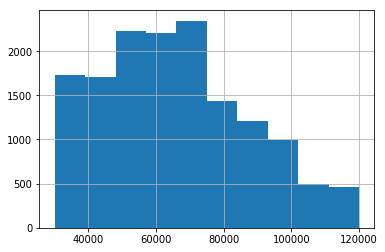

In [11]:
#check distributions of income
profile.income.hist()

<B>Last but not least, the became_member_on column may be feature-engineered to provide the membership tenure in days. This characteristic could play a role in the success or failure of an offer.

In [12]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

## 3.Transactional records

The transactional data schema is as follows:

<b>transcript.json</b>

record description for the event (str) (e.g., transaction, offer received, offer seen, etc.).
customer id, person (str), and time (int), expressed in hours. Data entry time is t=0.
value - (dict of strings) - Depending on the record, either an offer id or the transaction amount

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

<b>This data appears to be a little trickier because it is time-ordered, contains an event, and has a value. Depending on the event, it will be necessary to preprocess the value column in specific.

In [15]:
#checking the number of unique people represented
transcript['person'].nunique()

17000

<b>It appears that there are the same number of people in the transcript and the demographic data, which is encouraging. But a lot more preprocessing will be necessary before this dataset can yield any useful insights.

In [16]:
#checking forthe null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

<b>This data has no null values.

I will need to expand the values into different columns based on the event in order to draw conclusions from the value column.

In [17]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)


In [18]:
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [19]:
#creating the new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#dropping unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#renaming offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [20]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Defining the preparation strategy for the model's data

I went back to my goal before starting to preprocess the data for the model. I had to reconsider how I would clean and prepare the data for the models I intended to develop after conducting a preliminary analysis of the data.

I must first define a 'effective' offer within the Starbucks app in order to pinpoint the primary factors that influence an offer's effectiveness. As a result, I investigated the datasets and their potential interactions further.

I had to first investigate the types of events that each offer type contains.

In [21]:
#rename column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [22]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

We are aware that there are four different types of events: offers that have been completed, received, seen, and transactions. But according to our data, since these transactions are not noted in the transcript event data, we do not have any offer_ids linked with them. As a result, the initial goal of data preparation is to specify a way for associating offer_ids with particular transactions.

Furthermore, we are aware that when deals are finished, BOGO and discount offers have an offer completed event. This event is not related to informational offerings, though. As a result, we also outline the methodology for defining a successful offer as follows:

A BOGO and discount offer would be considered effective if the following things happened in the correct order and at the right times:
Received offer, viewed offer, completed transaction, and completed offer

Since an informational offer has an associated offer completed event, I will have to define transactions as a conversion to an effective offer in the meantime:

Received offer, viewed offer, and transaction.

## Data Preprocessing
### 1. Assigning offer ids to transactions
Once the approach has been defined, the next step is to identify ways to assign offer IDs to specific transactions. This involves categorizing customers into four main groups. 

The first group includes customers who were influenced by an offer and successfully converted. For BOGO or discount offers, this involves the events "offer received," "offer viewed," "transaction," and "offer completed." For informational offers, it includes "offer received," "offer viewed," and "transaction" events that occur within the offer's validity period. 

The second group consists of customers who received and viewed an offer but did not convert. In this case, only the "offer received" and "offer viewed" events occur. 

The third group includes customers who completed an offer or transaction regardless of their awareness of any offers. This group comprises several different event sequences, including only "transaction" events, "offer received" followed by a "transaction" and then an "offer completed" and "offer viewed" event, and other similar sequences. 

The fourth group comprises customers who received offers but did not take any action, and only the "offer received" event occurs. 

To distinguish between ineffective offers in group 2 and non-responsive customers in group 4, we need to check for cases where there is an "offer received" and "offer viewed" event but no conversion event. 

After categorizing customers, we need to define the target variable "effective offer." Group 1 customers who successfully converted are our target variable with "effective_offer=1." Group 2 customers who viewed an offer but did not convert are our target variable with "effective_offer=0." 

Groups 3 and 4 customers are deprioritized from our model. Group 3 customers are those who would have made a purchase regardless of an offer, while group 4 customers are low-priority customers who do not take any action, regardless of whether they receive an offer or not. 

To assign offer IDs that influence a transaction, we need to ensure that the transaction occurs after an "offer viewed" event. We can filter the transcript dataset by events "offer viewed" and "transaction" and use the pandas "ffill()" method to fill every transaction with the offer ID of the viewed offer, only if it occurs before the transaction, after sorting the dataset by person and time.


In [23]:
#define dropcolumns function as I will be doing this many times
def drop_cols(drop_cols,df,inplace=False):
    '''
    inputs:
    - drop_cols: list or string of column name to be dropped
    - df: dataframe from which column should be dropped
    - inplace: specify whether columns are dropped in place or not
    
    outputs:
    - Returns dataframe with dropped columns.
       
    '''
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    return df

In [24]:
#dropping unnecessary columns to clean dataset
transcript=drop_cols(['reward_x','reward_y'],transcript)
#sorting events by person and time
transcript=transcript.sort_values(['person','time'])

In [25]:
#filtering the  dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offers_view_transacted=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

<b>I can construct a new dataset with the filled-in offer ids for transactions because the aforementioned temporary dataset is merely a subset of the transcript dataset.

In [26]:
transcript=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [27]:
#cleaning up dataset to unify multiple offer_id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

drop_cols(['offer_id_x','offer_id_y'],transcript,inplace=True);

In [28]:
transcript = transcript.merge(portfolio, how='left', on='offer_id')
transcript['duration'] = np.where(transcript['duration_x'].isnull(), transcript['duration_y'], transcript['duration_x'])

# Drop unnecessary columns and rename columns
transcript.drop(['duration_x', 'duration_y', 'offer_type_x', 'difficulty_x', 'channels_x'], axis=1, inplace=True)
transcript.rename(columns={'reward_x':'reward', 'channels_y':'channels', 'offer_type_y':'offer_type', 'difficulty_y':'difficulty'}, inplace=True)

In [29]:
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### 2. Marking completed transactions and offers after offers have been viewed

The identification of a completed offer and transactions that take place after an offer is viewed is a crucial next step in getting our data ready for modeling and analysis.
When we have identified a transaction as taking place after an offer is viewed, I can utilize that knowledge to subset my data into the aforementioned groups and conduct analysis within each of them.
We can identify the converted transactions and completed offers using our dataset, which has the offer_ids filled in for transaction events. 
 - To begin with, we must confirm that the offer id from the prior event is the same. We can utilize the offer_id field to confirm that the preceding offer includes those events since we have tagged the offer id for all views, transactions, and completed offers.
 - This means that we can be sure that a transaction and/or completed offer are only occuring after an offer is viewed as long as the events offer viewed, transaction, and offer completed occur in the same event area and are in the proper sequence of time.

 - To accomplish this, I used pandas' shift function to create a new column and flag the previous offer id.

In [30]:
#get sample space of events consisting of offer viewed, transactions and offer completed
offers_viewed_transactions_completed=transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [31]:
#add extra column to flag the previous offer id
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [32]:
#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)

All we need to do to ensure we have our complete dataset once more is append the all offers received events in the transactions_clean dataset to our dataset offers_viewed_transactions_completed, which already includes all other potential events.

In [33]:
#get only offer received events
offers_received=transcript[transcript['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

#append datasets to complete dataset of transactions
transcript=offers_received.append(offers_viewed_transactions_completed)

#sort values
transcript=transcript.sort_values(['person','time'])

<b>We may now go back to the four customer groups of distinct person-offer_id pairs we are trying to analyze as we have assigned offer_ids for transactions for which an offer viewed event had previously occurred.

We must first divide the transcript into 3 different offer types in order to account for the varying treatment in assigning the target variable since we evaluate the conversion events of depending on offer type differently.

In [34]:
#define function to split into 3 offer types
def split(offer_type,grp_df):
    '''
    Splits dataframe to groups of specified offer type.
    
    inputs:
    - offer_type: specify offer type name in string format 
    - grp_df: original transcript dataframe to split on offer type
    
    outputs:
    - Returns dataframe containing data of just offer type.
       
    '''
    df=grp_df[grp_df['offer_type']==offer_type].copy()
    return df

#split transcript into 3 different offer types
transcript_bogo=split('bogo',transcript)
transcript_discount=split('discount',transcript)
transcript_info=split('informational',transcript)

<b>We are able to separate each unique person-offer_id in group 1 from the rest within each offer type using the `valid_completed` column. By identifying conversion events (either a `transaction` or an `offer completed` event, depending on the offer type) that occur after an `offer viewed` event and flagging them with `valid_completed=1`, we can ensure that any conversion events with this flag are at least in the first group, which includes people who were influenced and successfully converted due to effective offers.

For BOGO and discount offers, we will only consider `offer completed` events as conversion events, while for informational offers, we can consider the `transaction` event as the conversion event.

In [35]:
#since will do this for both BOGO and discount, define function for repeated operation
def grp1(df):
    '''
    Subsets dataframe to just group 1 members.
    
    inputs:
    - df: original transcript dataframe 

    outputs:
    - Returns dataframe containing transcript data of just group 1 users.
       
    '''
    grp1=df[['person','offer_id']][(df['valid_completed']==1) & (df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    return grp1

grp1_bogo=grp1(transcript_bogo)
grp1_discount=grp1(transcript_discount)

<b>For informational offers, we will defer defining group 1 until later because we have an additional factor to consider for transactions. Specifically, in order for transactions to be considered effective offers for informational offers, they must occur within the offer's validity period.

Moving on to BOGO and discount offers, we can now focus on differentiating the unique person-offer_ids in group 2 and group 4. To do this, we only need to examine the subset of people who have had an `offer received` and `offer viewed` event but no conversion events. We can assume that anyone who views an offer must have received it previously, so we can start by taking the entire group of people who received the offer and then subset them

In [36]:
#again, we define a function as we will repeat this for 2 datasets - BOGO & discount
def no_conv(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events
       
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

#check how many are in either group
check_merge_bogo=no_conv(transcript_bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=no_conv(transcript_discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


<b>We observe that there are a considerable number of unique person-offer_id pairs that have an `offer received` event but no corresponding conversion event. Based on our definition, these pairs would fall into either group 2 or group 4 within each offer type.

For those individuals in this subset who also have an `offer viewed` event, we can safely conclude that they belong to group 2, since it is reasonable to assume that anyone who has viewed an offer must have previously received it as well.

In [37]:
#define group 2 & 4 function as will repeat this for BOGO and discount offers
def grp_2_4(df):
    
    '''
    Takes in output dataframe from no_conv function to split into group 2 and 4 customers.
    
    inputs:
    - df: output dataframe from no_conv function
    
    outputs:
    - Returns 2 dataframes containing unique person-offer_id pairs with dataframe containing only group2 customers first, followed by dataframe containing only group 4 customers. 
       
    '''
    
    #subset to check group 2 and 4
    grp_2_4=df[df['_merge']=='right_only']

    #remerge with transcript to get events
    grp_2_4=grp_2_4.merge(transcript,how='left',on=['person','offer_id'])

    #within this subset, separate people with offer viewed event, and people with offer received but no offer viewed
    grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
    
    #remerge with full dataset and get remaining to get grp4
    drop_cols('_merge',grp_2_4,inplace=True)
    grp4=grp_2_4.merge(grp2[['person','offer_id']],how='left',indicator=True)
    grp4=grp4[grp4['_merge']=='left_only'].copy()
    
    return grp2,grp4

grp2_bogo,grp4_bogo=grp_2_4(check_merge_bogo)
grp2_discount,grp4_discount=grp_2_4(check_merge_discount)

<b>Group 3 individuals are those who have been successfully converted, but did not have an `offer viewed` event prior to their conversion event. In other words, they had no record of having viewed the offer before they made a purchase or completed the offer. 

For BOGO and discount offers, Group 3 individuals would be those who have an `offer completed` event, but with a `valid_completed` value that is not equal to 1.

In [38]:
def grp3(df):
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
       
    '''
    
    #check all conversion events with invalid conversions
    grp3=df[['person','offer_id']][(df['event']=='offer completed') & (df['valid_completed']!=1)].groupby(['person','offer_id']).count().reset_index()
    return grp3

grp3_bogo=grp3(transcript_bogo)
grp3_discount=grp3(transcript_discount)

<b>Now we have split our data into 4 different customer groups for the BOGO and discount offers. Next, we have to consider the effective and ineffective offers depending on the group type. As already elaborated above, any unique person-offer_id belonging to group 1 can be considered in our target variable `effective_offer=1` group.

Meanwhile, group 2 is in our target variable `effective_offer=0` group. For customers in groups 3 and 4, I deprioritise them for model implementation, but will be doing some exploratory analysis on them later.

In [39]:
def offers(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

offers_bogo=offers(grp1_bogo,grp2_bogo)
offers_discount=offers(grp1_discount,grp2_discount)

<b>We have now completed the process of creating target variables for the BOGO and discount datasets.

However, for informational offers, there is an additional factor we must take into account before tagging the effective offers column - namely, the validity of the offer.

### 3. When analyzing converted transactions and offers to determine whether they are effective, we must also take into account the duration or validity of the offer. This is particularly relevant for informational offers, as the conversion event is a transaction rather than an `offer completed` event.

For informational offers, we can consider the duration of the offer to be the length of the influence period. Therefore, we can assume that an offer is only effective if the transaction occurs within the duration of the offer.

On the other hand, for BOGO and discount offers, we can assume that if there is an `offer completed` event, it must have occurred within the duration of the offer, as it would not make sense for an offer to be completed after its validity period has ended.

As noted in our data dictionary, event times in the `transcript` data are recorded in hours. To ensure that they are on the same scale as the offer duration, we must convert them to days.

In [40]:
#converting the time into days
transcript_info['day_offer']=transcript_info['time']/24
#dropping unnecessary columns
drop_cols(['time','value','offer_id_previous'],transcript_info,inplace=True);

In [41]:
#sorting transactions to ensure all events occurring by person and offer
transcript_info=transcript_info.sort_values(['person','day_offer','event','offer_id'])

<b>To calculate the duration of an offer for each transaction, we can use the `diff` function in pandas to find the difference between two events. Specifically, we can find the difference between the `transaction` and the `offer received` events to obtain the duration of the offer.

In [42]:
#getting the difference in time for informational offers
transcript_info['diff_info']=transcript_info[(transcript_info['offer_type']=='informational') & ((transcript_info['event']=='offer received') | (transcript_info['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [43]:
#creating the column for flagging valid events
transcript_info['valid_completed_duration']=np.nan

#flaging the valid events if within duration
transcript_info.loc[transcript_info['diff_info']<=transcript_info['duration'],'valid_completed_duration']=1

#filling any missing values with 0 flag
transcript_info['valid_completed_duration']=transcript_info['valid_completed_duration'].fillna(value=0)

The `transcript_info` dataset has 4 possible scenarios for an informational offer, based on the `valid_completed` and `valid_completed_duration` flags:

1. `valid_completed`=1, `valid_completed_duration`=0: the customer completed the transaction after viewing the offer, but not within the offer duration. This scenario would put the customer in Group 3, which consists of people who complete offers regardless of awareness of any offers.

2. `valid_completed`=0/null, `valid_completed_duration`=1: the customer completed the transaction within the offer duration, but did not view the offer prior. This scenario would also put the customer in Group 3.

3. `valid_completed`=1, `valid_completed_duration`=1: the customer completed the transaction within the offer duration and viewed the offer prior. This scenario would put the customer in Group 1, which represents customers for whom the offer was effective.

4. `valid_completed`=0/null, `valid_completed_duration`=0: the customer did not complete the transaction within the offer duration and did not view the offer prior. This scenario would put the customer in Group 4, which only consists of transactions.

To separate customers in Group 2, who may have received and viewed an offer but did not complete any transactions, we need to subset those where `effective_offer!=1` into Groups 2, 3, and 4.

In [44]:
#flagging the effective_offers where valid_completed=1 and valid_completed_duration=1
transcript_info['effective_offer']=np.where(((transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']==1)),1,0)

<b>After tagging the effective offers, we can separate them into the four previously defined customer groups. Furthermore, we can apply a filter to only include events where `effective_offer=1`, as we are only interested in effective transactions that were influenced by an offer, not other transactions.

In [45]:
#separating the group 1 in transcript_into
grp1_info=transcript_info[['person','offer_id']][transcript_info['effective_offer']==1].groupby(['person','offer_id']).sum().reset_index()

<b>We need to further categorize the customers who did not fall into group 1 into groups 2 and 4. We can follow a similar process as we did for the BOGO and Discount offers, as we do not need to consider duration in this case.

In [46]:
#separating out the group 2 of customers
check_merge_info=no_conv(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [47]:
grp2_info,grp4_info=grp_2_4(check_merge_info)

<b>In order to identify customers in group 3, we need to look for those who completed an offer without viewing it first. This means we need to consider customers with conversion events but no offer viewed event prior. For informational offers, this corresponds to `transaction` events in Scenario 1 and 2 as described above.

In [48]:
#situation 1
grp3_1=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']!=1) & (transcript_info['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#situation 2
grp3_2=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

In [49]:
offers_info=offers(grp1_info,grp2_info)

### 4. In the feature engineering step, we need to be creative and generate new features. One such feature is based on the `became_member_on` column. During the preliminary data exploration, we observed that this column contains date values. Therefore, we can create a new feature that represents the tenure of membership to extract meaningful insights. It is possible that the duration of a person's membership could have an impact on whether or not they accept an offer.

In [50]:
#rename column for merging
profile.rename(columns={'id':'person'},inplace=True)

#create function to reuse for 3 datasets
def member(df):
    '''
    inputs:
    - df: original dataframe to transform became_member_on column  
    
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df=drop_cols('became_member_on',df)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df=drop_cols(['year','month','day'],df)
    
    return df

offers_bogo=member(offers_bogo)
offers_discount=member(offers_discount)
offers_info=member(offers_info)

### 5. During further analysis of the data, it was observed that each person may have received multiple offers.

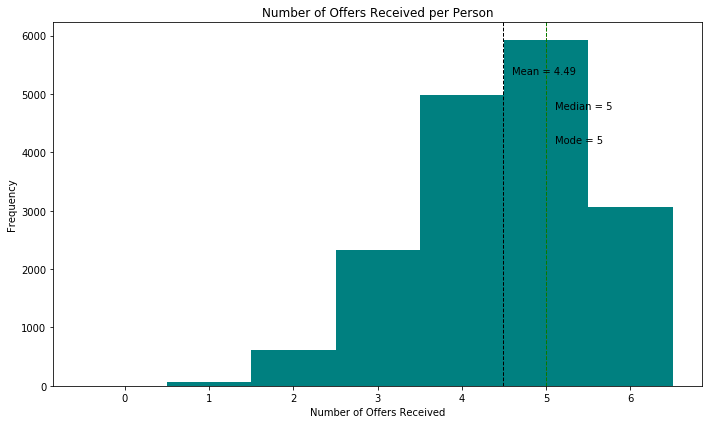

In [51]:
import matplotlib.pyplot as plt

# Group offers received by person
offers_received = transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count()

# Create a histogram of offers received
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(offers_received, bins=range(0, offers_received.max()+2), align='left', color='#008080')

# Set chart title and axis labels
ax.set_title('Number of Offers Received per Person')
ax.set_xlabel('Number of Offers Received')
ax.set_ylabel('Frequency')

# Add vertical line for mean
mean_val = offers_received.mean()
ax.axvline(mean_val, color='black', linestyle='dashed', linewidth=1)
ax.text(mean_val+0.1, n.max()*0.9, 'Mean = {:.2f}'.format(mean_val))

# Add text for median and mode
median_val = offers_received.median()
ax.axvline(median_val, color='red', linestyle='dashed', linewidth=1)
ax.text(median_val+0.1, n.max()*0.8, 'Median = {}'.format(int(median_val)))
mode_val = offers_received.mode()[0]
ax.axvline(mode_val, color='green', linestyle='dashed', linewidth=1)
ax.text(mode_val+0.1, n.max()*0.7, 'Mode = {}'.format(mode_val))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

<b>The output above shows that the number of offers received per person in the transactional data can vary from 1 to 6. To investigate whether the frequency of offers received per person affects the effectiveness of offers, a new feature called `offer_received_cnt` will be created to capture this information.

In [52]:
#getting the count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript[transcript['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#dropping unnecessary columns
drop_cols('time',df_offer_received_cnt,inplace=True)

#ensuring only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

### 6. I wanted to investigate how many transactions could be considered 'invalid' based on my definition and how this could potentially affect the effectiveness of offers. Typically, invalid transactions would be those done by users not in group 1, as the objective of offers is to drive purchases. Users with high spending tendencies are already flagged as `effective_offers`, which are separated into groups 3 and 4.

For users in group 1, it is possible that a high amount of 'invalid spend' outside the influence of offers may still be present, which could have some predictive power on the effectiveness of offers. For instance, loyal users may have a higher likelihood of taking up an offer.

I have already separated the transactions that are conversions from those that represent normal purchasing behavior in my dataset, using the `valid_completed` column. Transactions with a `valid_completed`=1 have been included in my effective offers flag for BOGO and Discount offers, while those with `valid_completed`=0 have not been considered. However, these transactions may still be a valuable feature to include as a proxy for the baseline spending level of a user. The question is whether there is any predictive power in this baseline level of 'invalid transactions' for users in group 1 and 2, to predict their propensity to take up

In [53]:
#filter dataset by invalid transactions
df_transactions_invalid=transcript[(transcript['event']=='transaction') & (transcript['valid_completed']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns={'amount':'amount_invalid'},inplace=True)

### 6. I also considered time as a potential feature to include in my dataset, but I realized that the time values in the transactional data start from zero and may not be very useful without some feature engineering. However, I suspected that if a person received multiple offers within a specific time period, the time elapsed between those offers might be a useful feature to include in predicting the effectiveness of the offers.

In [54]:
#convert time into days
transcript['day_offer']=transcript['time']/24
#drop unnecessary columns
drop_cols(['time'],transcript,inplace=True);

#find time elapsed between offers received
transcript['time_elapsed_offers']=transcript[transcript['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()

#fill missing values with 0, as if someone does not receive an offer or is receiving an offer for the first time, there is no time elapsed
transcript['time_elapsed_offers']=transcript['time_elapsed_offers'].fillna(value=0)

#create temporary dataset
df_time_elapsed=transcript.groupby(['person','offer_id'])['time_elapsed_offers'].sum().reset_index()

### 7. To prepare the data for modeling, we need to follow some additional steps for each dataset. These steps were identified during the preliminary data exploration phase:

a. Merge the datasets with the temporary datasets created earlier to include the engineered features.

b. Remove missing values in the `gender` column of the demographic data and convert gender into dummy variables.

c. Separate the `channel` column into categorical variables.

d. Handle duplicate records.

 -  Merge the datasets with the temporary datasets created earlier to include the engineered features.

In [55]:
#merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [56]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid            96.323752
income                     7.057489
gender                     7.057489
offer_received_cnt         0.000000
membership_tenure_days     0.000000
dtype: float64

<b>The missing values are significant, especially for the `amount_invalid` column. It's unclear whether including this column would be beneficial for the model, as it's very sparse for BOGO offers. I intend to re-evaluate this feature during the implementation stage of the model. For now, I opted to fill in the missing values for the `amount_invalid` column with 0, as it may indicate that only 3% of users make purchases without offers, while the other 97% only make purchases when there is an ongoing offer.

Furthermore, we have already assessed the `income` and `gender` columns, and since they are not useful when null, I decided to drop them from the dataset.

In [57]:
#filling the missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)

#dropping income and gender null rows
offers_bogo.dropna(inplace=True);

### 8.The `channel` column needs to be transformed into categorical variables to be used in modeling.

In [58]:
# reuse function so create rename function
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=drop_cols(col,df)
    return df

In [59]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
offers_bogo=pd.concat([offers_bogo[:], channels[:]], axis=1)
rename('web',offers_bogo)
rename('email',offers_bogo)
rename('mobile',offers_bogo)
rename('social',offers_bogo)
offers_bogo=drop_cols('channels',offers_bogo)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

<b>As we need to perform the same data preparation steps for the `offers_discount` dataset, I have created a function that includes all the aforementioned steps. This allows for a more efficient and streamlined process when preparing the data for modeling.

In [60]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',on='offer_id')

    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df=pd.concat([df[:], channels[:]], axis=1)
    rename('web',df)
    rename('email',df)
    rename('mobile',df)
    rename('social',df)
    df=drop_cols('channels',df)
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [61]:
#preparing the data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

In [62]:
#merging with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#resetting the index for offers_info
offers_info=drop_cols('index',offers_info.reset_index())

#expanding channel column into categorical variables
def channel_col(name,df=offers_info):
    '''
    inputs:
    - name: name of channel column to be transformed 
    - df: dataframe 
    
    outputs:
    - offer_info dataframe with channel column transformed
    
    '''
    df[name]= np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name]=df[name].fillna(value=0)
    return df

In [63]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

drop_cols('channels',offers_info,inplace=True);

In [64]:
#repurposing the function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

In [65]:
offers_info=prep_offers_df(offers_info)

In [66]:
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_tenure_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,1,0,0


 - As we have already divided the data into unique person-offer_id pairs by group, we anticipate having no duplicated records. Nevertheless, as a precautionary measure, we check for duplicate records to ensure data cleanliness.

In [67]:
#checking the multiple records for each person and offer ids for the target variable
print((offers_bogo.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_discount.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_info.groupby(['person','offer_id','effective_offer']).size()>1).sum())

0
0
0


## B. Execution
Datasets are ready for building models to analyze drivers of effective offers. Three different models will be built, one for each offer type, to predict the binary target variable `effective_offer`. A decision tree classifier model will be used as the baseline model for interpretability, and a random forest classifier model will be used as an alternate model for improved accuracy. The class balance will be checked before proceeding.

In [68]:
#checking for the class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


<b>The classes for all three offer types are uneven but not imbalanced enough to pose a problem. Both accuracy and F1 score will be used for model evaluation and validation. F1 score will be particularly useful for this case, as it takes into account false positives and false negatives in the calculation. The focus will be on whether offers are effective rather than why offers are ineffective.

### B.1 Model Execution

In [69]:
def data_prep(df,drop_cols_prep):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = drop_cols(drop_cols_prep,df)
    return features,target

 - Afterwards, I divided the data into training and testing sets. To ensure that all the features of my data have the same scale during the training process, I applied a scaler.

In [70]:
#prepare model pipeline
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

 - I'm creating a function to run 3 different models for easy implementation. It will calculate the F1 score, accuracy, and mean squared error. Since the classes for the BOGO and discount offers are uneven, I plan to compare F1 score and accuracy to assess model performance.

In [71]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [72]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

### The initial model for BOGO offers
is being created with some randomly chosen parameters to check its performance. If necessary, a Grid Search will be performed later to find the best parameters.

In [73]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1670
MSE_test: 0.1786
Training accuracy:0.8330
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



 - The accuracy of both the Random Forest Classifier (RF) and Decision Tree Classifier (DT) models for BOGO offers is about the same, but RF is slightly better. However, the F1 score for both models is below 80%, with DT outperforming RF. The F1 score is lower due to instances where negatives are falsely classified as positives, likely due to class imbalance. But this is not a concern for the use case. The RF model is selected, and feature importances will be checked later to

### Model for Discount Offerings

In [74]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1313
MSE_test: 0.1277
Training accuracy:0.8687
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



 - The Random Forest Classifier model outperforms the Decision Tree Classifier in terms of both accuracy (87.23% vs 86.72%) and F1 score (81.43% vs 82.87%). Although both models have lower F1 scores overall compared to accuracy, the higher accuracy model with better performance for positive cases will be selected, which is the RF classifier with an F1 score of 0.9317.

### Model Offers Information

In [75]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2367
MSE_test: 0.2491
Training accuracy:0.7633
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5636    0.0873    0.1512       355
          1     0.7586    0.9770    0.8540      1042

avg / total     0.7090    0.7509    0.6754      1397



 - The models for this dataset have worse performance compared to the other two, with RF model performing better with accuracy below 80% for both models. The F1 score is also worse, with RF Classifier at 67.

## C.To find the best parameters for the model, I used Grid Search for all three offers, and since the Random Forest model showed good performance, I applied it to this model.

In [76]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [10,20,25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [77]:
#defining the BOGO dataset
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [78]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1562
MSE_test: 0.1749
Training accuracy:0.8438
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5408    0.1210    0.1978       438
          1     0.8369    0.9777    0.9018      2020

avg / total     0.7841    0.8251    0.7764      2458



In [79]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.027338,0.047395
testing_score,0.821400,0.825061
train_time,0.148333,0.238580
training_score,0.833045,0.843829


In [80]:
#defining the function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

In [81]:
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.047395,0.825061,0.23858,0.843829


 - The accuracy and F1 score of the RF model improved slightly after parameter tuning. However, the improvement was not significant, suggesting that feature engineering may be necessary to enhance model performance.

In [82]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [83]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1324
MSE_test: 0.1253
Training accuracy:0.8676
Test accuracy:0.8747
             precision    recall  f1-score   support

          0     0.7500    0.0277    0.0534       325
          1     0.8752    0.9986    0.9329      2220

avg / total     0.8593    0.8747    0.8206      2545



In [84]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.031734,0.040944
testing_score,0.872299,0.874656
train_time,0.187825,0.265437
training_score,0.868749,0.867570


In [85]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.040944,0.874656,0.265437,0.86757


 - The RF model's accuracy and F1 score slightly increased to 87.47% and 82.06% respectively, surpassing the DT model's scores. However, since the improvement was minor, adjusting the parameters won't significantly boost model performance.

In [86]:
#define info dataset
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

In [87]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2405
MSE_test: 0.2470
Training accuracy:0.7595
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.5926    0.0901    0.1565       355
          1     0.7595    0.9789    0.8553      1042

avg / total     0.7171    0.7530    0.6778      1397



In [88]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.017007,0.015711
testing_score,0.750895,0.753042
train_time,0.115294,0.102029
training_score,0.763295,0.759534


In [89]:
#finding the best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015711,0.753042,0.102029,0.759534


 - There was a slight improvement in the accuracy of the RF model from 75.09% to 75.30%, and a slight increase in the F1 score from 67.54% to 67.78%. However, since the improvement is minimal, we need to focus on improving the feature selection of the model.

### d. To improve feature selection, I removed the sparse variable "amount_invalid" to see if it would affect the model's performance. The model was retrained with the same optimal parameters and compared to the baseline DT model.

In [90]:
#adding amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#trainning BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initializing the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1743
MSE_test: 0.1810
Training accuracy:0.8257
Test accuracy:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1531
MSE_test: 0.1717
Training accuracy:0.8469
Test accuracy:0.8283
             precision    recall  f1-score   support

          0     0.5889    0.1210    0.2008       438
          1     0.8374    0.9817    0.9038      2020

avg / total     0.7931    0.8283    0.7785      2458



In [91]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.047395,0.044282
testing_score,0.825061,0.828316
train_time,0.238580,0.260302
training_score,0.843829,0.846882


In [92]:
#finding the best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.044282,0.828316,0.260302,0.846882


 - The accuracy and F1 score of the model showed an improvement after removing the amount_invalid feature. Therefore, I will exclude this feature from the model.

In [93]:
#trainning the discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initializing the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1310
MSE_test: 0.1265
Training accuracy:0.8690
Test accuracy:0.8735
             precision    recall  f1-score   support

          0     0.5882    0.0308    0.0585       325
          1     0.8754    0.9968    0.9322      2220

avg / total     0.8387    0.8735    0.8206      2545



In [94]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.040944,0.045699
testing_score,0.874656,0.873477
train_time,0.265437,0.290734
training_score,0.867570,0.869044


In [95]:
#finding the best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.040944,0.874656,0.265437,0.86757


 - The accuracy of the model increased, but the F1 score stayed the same. As a result, I will also remove the amount_invalid feature for the discount model.

In [96]:
#trainning info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initializing the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2365
MSE_test: 0.2520
Training accuracy:0.7635
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5263    0.0845    0.1456       355
          1     0.7575    0.9741    0.8522      1042

avg / total     0.6987    0.7480    0.6727      1397



In [97]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.015711,0.027416
testing_score,0.753042,0.748031
train_time,0.102029,0.136338
training_score,0.759534,0.763474


In [98]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015711,0.753042,0.102029,0.759534


 - The accuracy and F1 score of the info model decreased after removing the amount_invalid feature, so the feature will be kept. This is because the model already had lower performance than the other two models, indicating underfitting and the need for more features to improve its predictions.

<b>To prevent multicollinearity between variables, typically one level of the variable should be removed in regression classification models. However, in tree-based models like the ones used here, there is debate as to whether this should be done. Sparse matrices generated by encoding categorical variables can lead to continuous variables being assigned higher feature importance and a high bar for a single level of a categorical variable to be selected for splitting, both of which can degrade predictive performance. Despite this, scikit-learn implementations of RF and DT require variable encoding. To reduce sparsity and noise, the author tested model performance by dropping one level of categorical variables in their data (

In [99]:
#adding one level of dummy variables to drop column 
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid','social','gender_O']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initializing the model - reuse best performing model - 
bogo_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_4,'bogo_4')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1743
MSE_test: 0.1810
Training accuracy:0.8257
Test accuracy:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1478
MSE_test: 0.1749
Training accuracy:0.8522
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5392    0.1256    0.2037       438
          1     0.8374    0.9767    0.9017      2020

avg / total     0.7843    0.8251    0.7774      2458



In [100]:
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_bogo_4']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_bogo_4
pred_time,0.044282,0.044800
testing_score,0.828316,0.825061
train_time,0.260302,0.299112
training_score,0.846882,0.852172


In [101]:
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.044282,0.828316,0.260302,0.846882


 - The performance of this model was inferior to the previous one. Therefore, I will retain all levels of variables in the model.

In [102]:
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
discount_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_4,'discount_4')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1308
MSE_test: 0.1269
Training accuracy:0.8692
Test accuracy:0.8731
             precision    recall  f1-score   support

          0     0.5714    0.0246    0.0472       325
          1     0.8748    0.9973    0.9320      2220

avg / total     0.8360    0.8731    0.8190      2545



In [103]:
results[['RandomForestClassifier_discount_3','RandomForestClassifier_discount_4']]

,RandomForestClassifier_discount_3,RandomForestClassifier_discount_4
pred_time,0.045699,0.043650
testing_score,0.873477,0.873084
train_time,0.290734,0.310196
training_score,0.869044,0.869241


In [104]:
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.040944,0.874656,0.265437,0.86757


 - The performance of this model was inferior to the previous one. Therefore, I will retain all levels of variables in the model.

In [105]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
info_4 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_4,'info_4')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2380
MSE_test: 0.2520
Training accuracy:0.7620
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5205    0.1070    0.1776       355
          1     0.7606    0.9664    0.8512      1042

avg / total     0.6996    0.7480    0.6800      1397



In [106]:
results[['RandomForestClassifier_info_3','RandomForestClassifier_info_4']]

,RandomForestClassifier_info_3,RandomForestClassifier_info_4
pred_time,0.027416,0.017536
testing_score,0.748031,0.748031
train_time,0.136338,0.113879
training_score,0.763474,0.762041


In [107]:
#finding the best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015711,0.753042,0.102029,0.759534


<b>In general, we did not observe much improvement in the model's performance by removing one level of categorical features. Although I am content with the BOGO and discount models' performance, I want to investigate whether I can enhance the information model's performance.

### e. Try to use polynomial properties
 - Due to the low accuracy score for the info model, which is possibly due to the model underfitting, I decided to try to improve the model's performance by transforming the features further. I modified my model_pipeline function to include a polynomial feature transformation of my features.

In [108]:
#preparing the model pipeline
def model_pipeline_poly(features,target,poly_feat=0):
    '''
    input:
    - features & target dataframes
    - poly_feat: number of degrees to transform polynomial features
    
    output:
    - X_train, X_test, y_train, y_test dataframes
    
    '''
    
    #spliting into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    #fitting and transforming training data
    poly = PolynomialFeatures(poly_feat)
    X_train_poly=poly.fit_transform(X_train)
    
    #transforming test data
    X_test_poly=poly.transform(X_test)
    
    #fitting and transforming scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train_poly)

    #scaling test data
    X_test=scaler.transform(X_test_poly)
    return X_train,X_test,y_train, y_test

In [109]:
#keeping the amount_invalid in offers_info dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initializing the model
info_5 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_5,'info_5')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2448
MSE_test: 0.2491
Training accuracy:0.7552
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5393    0.1352    0.2162       355
          1     0.7653    0.9607    0.8519      1042

avg / total     0.7079    0.7509    0.6904      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2249
MSE_test: 0.2534
Training accuracy:0.7751
Test accuracy:0.7466
             precision    recall  f1-score   support

          0     0.5054    0.1324    0.2098       355
          1     0.7638    0.9559    0.8491      1042

avg / total     0.6981    0.7466    0.6867      1397



In [110]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_5']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_5
pred_time,0.015711,0.021122
testing_score,0.753042,0.746600
train_time,0.102029,0.211642
training_score,0.759534,0.775112


In [111]:
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015711,0.753042,0.102029,0.759534


 - The performance of the RF model decreased slightly, so it may be best to keep the model as is. An accuracy of 75.30% is acceptable for the info offers, although not as high as the BOGO or discount offers. Considering that some assumptions were already made for the influence of the offer based on the duration, it may not be necessary to further improve the model.

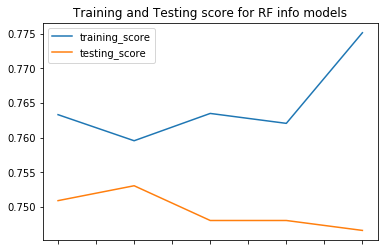

In [112]:
results.loc[['training_score','testing_score'],['RandomForestClassifier_info_1','RandomForestClassifier_info_2','RandomForestClassifier_info_3','RandomForestClassifier_info_4','RandomForestClassifier_info_5']].transpose().plot.line()
plt.title('Training and Testing score for RF info models')
plt.show()

<b>The training accuracy improved as more variables were added through polynomial features and removing the amount_invalid feature, but testing accuracy decreased due to overfitting. To improve the accuracy of the info model, adding more data can help since the dataset is smaller compared to BOGO and discount datasets. With more data and performance tuning, the model's accuracy could have been above 80%. The best models for all three can now be evaluated, and feature importances can be checked to identify the top drivers of effectiveness of offers.

In [113]:
#getting the best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.044282,0.040944,0.015711
testing_score,0.828316,0.874656,0.753042
train_time,0.260302,0.265437,0.102029
training_score,0.846882,0.867570,0.759534


 - In summary, the top-performing models for BOGO and discount offers are the 3rd model, while for informational offers, it's the one after performing GridSearch. To identify the key drivers of effective offers, we can look at the feature importances of these models.

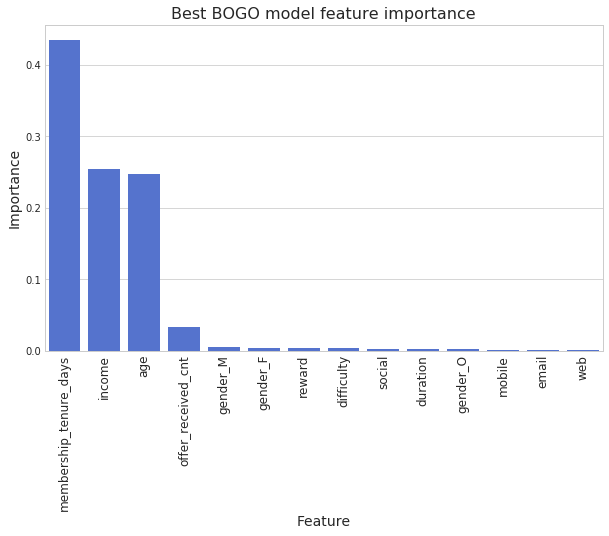

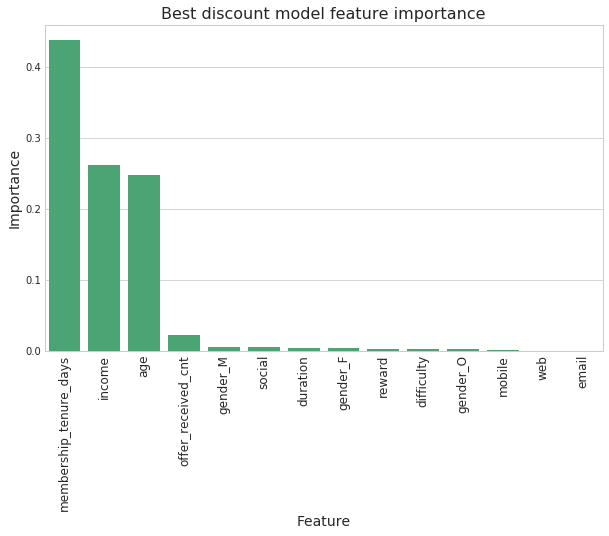

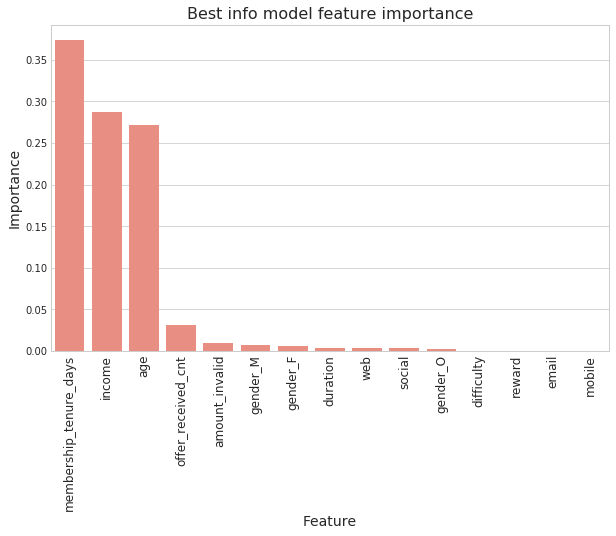

In [114]:
# BOGO 3 model
# prepare data same as BOGO 3 state
import seaborn as sns
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target=data_prep(offers_bogo,drop_cols_prep)

# train the model
bogo_3 = RandomForestClassifier(random_state=42)
bogo_3.fit(features,target)

# get feature importances
feature_importances = pd.DataFrame(bogo_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

# plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.index, y=feature_importances.importance, color='royalblue')
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Best BOGO model feature importance', fontsize=16)
plt.show()

# discount 3 model
# prepare data same as discount 3 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target=data_prep(offers_discount,drop_cols_prep)

# train the model
discount_3 = RandomForestClassifier(random_state=42)
discount_3.fit(features,target)

# get feature importances
feature_importances = pd.DataFrame(discount_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

# plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.index, y=feature_importances.importance, color='mediumseagreen')
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Best discount model feature importance', fontsize=16)
plt.show()

# info_2 model
# prepare data same as info 2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)

# train the model
info_2 = RandomForestClassifier(random_state=42)
info_2.fit(features,target)

# get feature importances
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

# plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.index, y=feature_importances.importance, color='salmon')
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Best info model feature importance', fontsize=16)
plt.show()

 - The feature importance analysis reveals that membership tenure is the most important driver of an effective offer across all three models. However, the second most important feature varies among the three models. For the BOGO model, income, age, and offer_received_cnt are the next important features. For the discount model, age and income are important. The feature importances for the informational offer model are more evenly distributed, with income being the second most important feature, followed by age and mobile channel.

## F. Analyzing the demographics of users in groups 3 and 4, who make purchases without viewing offers. To compare these users with those in groups 1 and 2, some exploratory analysis is needed. The first step is data preparation.

In [115]:
#appending the datasets together

#group 3+ group4
grp3_4=grp3_bogo.append(grp3_discount,sort=False)
grp3_4=grp3_4.append(grp3_info,sort=False)
grp3_4=grp3_4.append(grp4_bogo,sort=False)
grp3_4=grp3_4.append(grp4_discount,sort=False)
grp3_4=grp3_4.append(grp4_info,sort=False)

#group1
grp1_all=grp1_bogo.append(grp1_discount,sort=False)
grp1_all=grp1_all.append(grp1_info,sort=False)

#group2
grp2_all=grp2_bogo.append(grp2_discount,sort=False)
grp2_all=grp2_all.append(grp2_info,sort=False)

#getting the unique person-offer_id pairs
grp3_4=grp3_4[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp1_all=grp1_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp2_all=grp2_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

#getting the membership_tenure_days
grp3_4=member(grp3_4)
grp1_all=member(grp1_all)
grp2_all=member(grp2_all)

#mergingwith transcript to check transaction amount
grp3_4=grp3_4.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp1_all=grp1_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp2_all=grp2_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')

<b>We need to remove any missing values from the dataset, just like we did while preparing the data for modeling.

In [116]:
#checking the null values
print("For grp 3 and 4:")
print((grp3_4.isnull().sum()/len(grp3_4))*100)

#dropping the null values
grp3_4=grp3_4.dropna()

#checking the null values
print("For grp 1:")
print((grp1_all.isnull().sum()/len(grp1_all))*100)

#dropping the null values
grp1_all=grp1_all.dropna()

#checking theping null values
print("For grp 2:")
print((grp2_all.isnull().sum()/len(grp2_all))*100)

#dropping null values
grp2_all=grp2_all.dropna()

For grp 3 and 4:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    9.019155
income                    9.019155
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 1:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    5.896762
income                    5.896762
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 2:
person                     0.000000
offer_id                   0.000000
age                        0.000000
gender                    21.131608
income                    21.131608
membership_tenure_days     0.000000
amount                     0.000000
dtype: float64


In [117]:
#checking groups sizes
print("Size of group 1: "+ str(len(grp1_all['person'])))
print("Size of group 3+4: "+ str(len(grp3_4['person'])))
print("Size of group 2: "+ str(len(grp2_all['person'])))

Size of group 1: 26507
Size of group 3+4: 18904
Size of group 2: 5729


<b>Group 1 is the biggest, while group 2 is the smallest due to the dataset's imbalanced positive classes. However, groups 3 and 4 have a substantial number of individuals. To compare the groups effectively, a function was developed for visualizing them together.

In [118]:
#creating the function for plotting multiple histograms overlaying the 3 groups
def plot_hist(variable,bins=None):
    plt.hist(grp1_all[variable],alpha=0.5, label='group 1',bins=bins)
    plt.hist(grp3_4[variable], alpha=0.5, label='group 3 and 4',bins=bins)
    plt.hist(grp2_all[variable], alpha=0.5, label='group 2',bins=bins)
    plt.legend(loc='upper right')
    plt.title('distribution of '+ variable + ' between group 1, group 2 and groups 3 + 4')
    plt.show()

 - To begin with, we can examine how the income is distributed among the 3 groups.

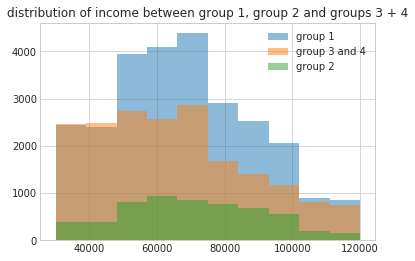

In [119]:
#plotting the distribution of income
plot_hist('income')

 - The majority of individuals in all three groups have an income within the range of 50K to 100K. The income distribution among the three groups is quite comparable.

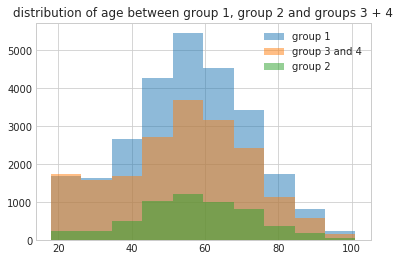

In [120]:
#plotting the ditribution of age
plot_hist('age')

 - The age distribution among the three groups is quite similar, with the majority of individuals being between the ages of 40 and 80.

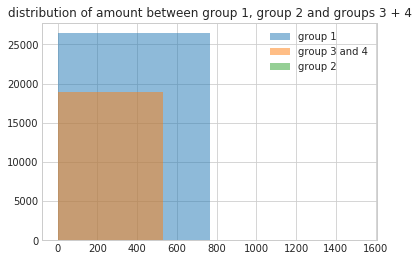

In [121]:
#plotting the distribution of amount to spent and given an effective offer
plot_hist('amount',bins=2)

 - Group 2 is not shown in the graph as they did not spend any money due to ineffective offers. However, for groups 1 and 3+4, we can observe a similar amount of spending, with group 1 having slightly higher spending. This is reasonable as the offers may have encouraged group 1 to spend more, resulting in higher overall spending.
 

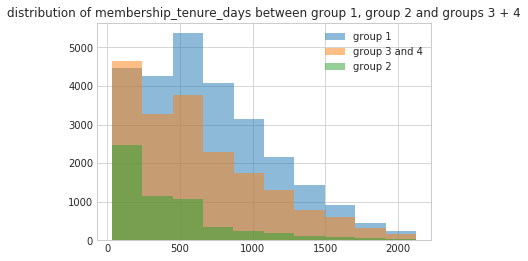

In [122]:
#plot tenure of membership
plot_hist('membership_tenure_days')

 - The membership tenure distribution is similar among the three groups, with most users having a tenure of 0-700 days. This indicates that there are no significant demographic differences among the groups based on the available data.

### g. I was curious if we could predict offer effectiveness by including the offer type as a categorical feature. I wanted to explore if the type of offer has an impact on the user's responsiveness. To achieve this, I need to perform some data preparation to prepare the data for a multiclass model.

In [144]:
#append datasets together
offers_bogo['offer_type']='bogo'
offers_info['offer_type']='informational'
offers_discount['offer_type']='discount'
offers=offers_discount.append(offers_bogo,sort=False)
offers=offers.append(offers_info,sort=False)

#create dummy variable for offer_type categorical variable
offers=dummy(offers,'offer_type')

In [145]:
#do grid search to find optimal parameters for RF model
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

rand_forest_param_selection(X_train, y_train)

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 50}

In [146]:
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
all_in_one = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 2,n_estimators=50,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,all_in_one,'all_in_one')],axis=1)

DecisionTreeClassifier trained on 25594 samples.
MSE_train: 0.1761
MSE_test: 0.1753
Training accuracy:0.8239
Test accuracy:0.8247
             precision    recall  f1-score   support

          0     0.5269    0.0778    0.1356      1131
          1     0.8326    0.9850    0.9024      5268

avg / total     0.7786    0.8247    0.7669      6399

RandomForestClassifier trained on 25594 samples.
MSE_train: 0.1638
MSE_test: 0.1749
Training accuracy:0.8362
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5316    0.0893    0.1529      1131
          1     0.8341    0.9831    0.9025      5268

avg / total     0.7806    0.8251    0.7700      6399



In [147]:
#comparing best performance of all 3 models with all_in_one model
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_3,RandomForestClassifier_info_2,DecisionTreeClassifier_all_in_one,DecisionTreeClassifier_all_in_one,RandomForestClassifier_all_in_one,RandomForestClassifier_all_in_one
pred_time,0.044282,0.045699,0.015711,0.002853,0.002603,0.211120,0.205045
testing_score,0.828316,0.873477,0.753042,0.824660,0.824660,0.825129,0.825129
train_time,0.260302,0.290734,0.102029,0.092630,0.062648,1.373768,1.308957
training_score,0.846882,0.869044,0.759534,0.823904,0.823904,0.836212,0.836212


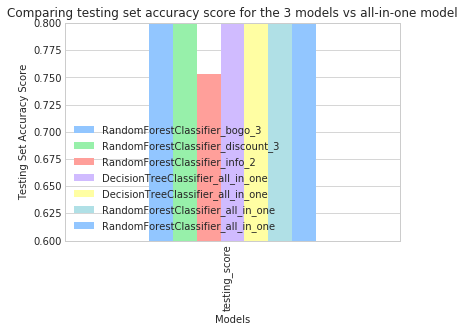

In [152]:
results.loc[['testing_score'],['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']].plot.bar()
plt.title('Comparing testing set accuracy score for the 3 models vs all-in-one model')
plt.legend(loc=3)
plt.xlabel('Models')
plt.ylabel('Testing Set Accuracy Score')
plt.ylim(0.6, 0.8)
plt.xticks(rotation=90, ha='right')
plt.show()

<b> The 3 best models for each offer type perform better than the all-in-one model, which is slightly better than the info model. The info model lowers the accuracy of the all-in-one model, and if we look at its ability to predict the effectiveness of informational offer types, it would also perform worse than predicting the other 2 types. It is more useful to have 3 separate models with higher accuracy because BOGO and discount offers drive sales with promotional cost, while informational offers are essentially free, so driving sales would be a bonus. Thus, the 3 separate models are more useful.

## H. Can we predict customer spend based on effective offers? 
I explored building a regression model to predict spend for each offer type, but also wanted to see if offer type would impact spending level. We have effective offer data for group 1 customers, so by summing their spend, we can investigate this relationship.

In [136]:
#append all 3 datasets together
grp1=grp1_bogo.append(grp1_discount,sort=False)
grp1=grp1.append(grp1_info,sort=False)

#drop unnecessary columns
drop_cols('effective_offer',grp1,inplace=True)

#get offer details
grp1=grp1.merge(portfolio,how='left',on='offer_id')

 - We consider only those transactions that are impacted by an offer (i.e., `valid_completed=1`) to forecast the spend based on the impact of an effective offer.

In [137]:
#get sum of valid transactions per person based on unique person and offer_id pair
grp1=grp1.merge(transcript[['person','offer_id','amount']][transcript['valid_completed']==1].groupby(['person','offer_id']).sum(),on=['person','offer_id'])

In [138]:
#get demographic data and membership_tenure details
grp1=member(grp1)

#reset index for offers_info
grp1=drop_cols('index',grp1.reset_index())

#reuse offers_info channel_col function to expand channel column into categorical variables
channel_col('web',grp1)
channel_col('email',grp1)
channel_col('mobile',grp1)
channel_col('social',grp1);

drop_cols('channels',grp1,inplace=True);

#reuse offers_info function to prep dataset
grp1=prep_offers_df(grp1)

#encode offer type as dummy variables
grp1=dummy(grp1,'offer_type')

 - To prevent multicollinearity in the regression model, we need to drop one level of the dummy variables, thus reducing their level by 1.

In [139]:
#add one level of dummy variable to drop
drop_cols_prep=['person', 'offer_id','amount','social','gender_O','offer_type_informational']
target=grp1['amount']
features=drop_cols(drop_cols_prep,grp1)

In [140]:
#tweak train_predict function -
def train_predict_reg(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    return results

In [141]:
def run_model_reg(clf1,clf2,name):
    '''
    input:
    - clf1: baseline regression model
    - clf2: 2nd regression model to compare
    - name: name to keep track of comparison
    output:
    - dataframe containing results of training and prediction of model
    
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict_reg(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

In [142]:
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initialize the model
clf1 = Ridge(alpha=2,random_state=2)
clf2 = DecisionTreeRegressor(random_state=2)

results_reg=run_model_reg(clf1,clf2,'reg')

Ridge trained on 21011 samples.
MSE_train: 5149.4918
MSE_test: 5264.4857
Training accuracy:0.0901
Test accuracy:0.0863
DecisionTreeRegressor trained on 21011 samples.
MSE_train: 0.0410
MSE_test: 11106.1821
Training accuracy:1.0000
Test accuracy:-0.9277


In [143]:
results_reg

,Ridge_reg,DecisionTreeRegressor_reg
pred_time,0.008297,0.013756
testing_score,0.086260,-0.927664
train_time,5.729329,1.702564
training_score,0.090122,0.999993


 - The regression models performed poorly in predicting the amount spent, possibly due to insufficient information in group 1 customer data. The Decision Tree Regressor overfit the data, while the linear regression model showed minimal correlation between features and target variables. Breaking the models into 3 based on offer type may improve performance, but exploring non-influenced/invalid transactions could be considered later.

# Conclusion
### Reflection:
#### Findings from Question 1
For Question 1, all 3 models ranked the length of a member's stay as the most important factor in predicting an offer's success. What typical tenure days might result in a successful BOGO offer could be determined by further research.
The top three factors for all three models were membership tenure, income, and age. Depending on the sort of offer, age and income were ranked differently.
The distribution of feature relevance for BOGO and discount offers was quite even. The distribution is a little bit more evenly distributed for informational offerings, with income ranking as the second most crucial factor.

<b>Results of question 2:</b>

After deciding to utilize three different models, I found that the BOGO and discount models performed well (82.83% for BOGO and 87.35% for discount), whereas informational offers performed only marginally less accurately (75.3%). In a professional atmosphere, I would consider 75% acceptable, as providing users with product knowledge is free for informational offers.

While this is going on, I am pleased with the BOGO and discount models' accuracy rates of 80% and above since, in a business situation where it would be allowed to present offers to customers, even if the model makes a few classification errors, the overall increase in income may outweigh those few errors.

### Main challenges and potential improvement:
When examining and constructing machine learning models to address the aforementioned questions, I encountered various challenges and made noteworthy observations. 

One significant challenge was developing an attribution framework for assigning offer_ids to transactions, which was necessary to address Question 1. To begin, I needed to establish a definition of an "effective offer" based on the transactional records. This proved to be the most difficult aspect of the project. I devised a funnel to determine what an effective conversion would entail, as we had data on both successful and unsuccessful conversions. Consequently, I designed an attribution model for the conversion events (offer completed and transaction events) based on the preceding events for each individual.

I ultimately separated users into four distinct categories based on their actions in the transcript data: 
1) those influenced by offers and therefore complete the offer (successful/effective conversion)
2) those who receive an offer but are not influenced and do not convert (unsuccessful/ineffective conversion)
3) those who have conversion events but were not influenced by an offer
4) those who receive offers but take no action or views.

Even after separating the groups, it was challenging to assign individuals in group 3 based on the transactional data. I had to establish an event space where the appropriate sequence of events would occur before I could assign an offer id to transactions that lacked an offer_id, effectively creating an event/sequence-based attribution window. 

After assigning conversions to specific offers, the remainder of the data preparation and cleaning process was relatively uncomplicated. I was thankful that there were few missing values, and the preparation of categorical variables was also relatively straightforward.

## Feature engineering:
During my initial attempt at this project, I noticed that the model had slightly underfit. To improve its performance, I decided to conduct some basic feature engineering, which I added later. The feature engineering section had a slight impact on improving the model's performance, and the membership_tenure feature, which I had created from the became_member_on column, turned out to be the most important predictor variable.

However, despite my suspicion that the time of receiving the offer may be a significant factor in determining its effectiveness, I was unable to think of any additional features using time data.

## Model implementation decisions:
Based on the problem statement of wanting to identify what drives an effective offer, I decided to build three separate models for each offer type. I believed that separating the data would help remove noise and produce better results. This decision turned out to be a good one as both the BOGO and discount models performed well in testing scores compared to the all-in-one model.

However, the accuracy of the info model was slightly worse due to the limited amount of data available. With more data, I believe that the accuracy could have been improved. As I made decisions to improve the model fit, such as adding polynomial features and removing 'noisy' features, the model began to overfit, resulting in a diverging pattern between the training and testing scores. Therefore, I think the model accuracy would have benefited from more data.

It's worth noting that I chose tree-based models as I wanted to assess feature importance, but I could have extended this study further by testing a parametric/regression model, such as logistic regression for classification tasks. The weight of coefficients from a regression model might have been interesting to compare with the feature importance of a tree-based model, as both models have different ways of analyzing the data. In such a case, the feature membership_tenure_days might not have been the highest weighted feature, as it was in this study.

## Exploring demographics of different customer groups:
I was interested in identifying the traits of groups 3 and 4, comprising customers who do not get influenced by offers. However, when I compared their demographics with those of groups 1 and 2, I did not notice any notable distinctions.

It would have been beneficial to have more data to gain insights into why this group of customers does not respond to offers, enabling me to provide practical recommendations for delivering a positive customer experience, even without providing them with any offers.

## Model accuracy in predicting amount spent given an effective offer:
Out of curiosity, I built a regression model to predict how much a user would spend if effectively influenced by an offer, with the aim of assessing which offers bring in the most revenue. However, the model showed little correlation between the provided features, such as offer characteristics and user demographics, and the amount spent per user. The features are not strong enough to predict the amount spent, and it may be helpful to include the value of the offer, such as the dollar value of a discount offer, to improve prediction accuracy.

Although I could have created separate models for the three offer types, as I did with the binary classification models, I chose to build an all-in-one model for this analysis, as it was just a curiosity and I wanted to explore if offer type was a significant predictor feature. However, further exploration of this topic would be worthwhile if more time and data were available.